In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import random

In [2]:
def plot_GP(pred_mean,pred_covar,train_inputs,train_outputs,test_inputs):
    fig, ax = plt.subplots()
    plt.plot(train_inputs, train_outputs, '+k')
    pred_mean = pred_mean.data.numpy()
    pred_sd = np.sqrt(pred_covar.data.numpy().diagonal())
    plt.plot(test_inputs, pred_mean, '+b')
    plt.plot(test_inputs, np.squeeze(pred_mean) + 2*pred_sd, '+r')
    plt.plot(test_inputs, np.squeeze(pred_mean) - 2*pred_sd, '+r')
    #plt.fill_between(np.squeeze(test_inputs), np.squeeze(pred_mean) + 2*pred_sd, 
    #                 np.squeeze(pred_mean) - 2*pred_sd, color='b', alpha=0.3)

# Toy dataset

In [97]:
lim = 20
resolution = 500

Xn = np.expand_dims(np.linspace(-lim,lim,resolution),1)
Yn = np.expand_dims(np.linspace(-lim,lim,resolution)+np.linspace(-lim,lim,resolution)*np.sin(np.linspace(-lim,lim,resolution)),1)

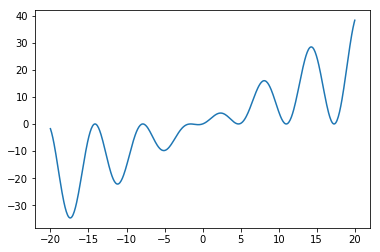

In [98]:
plt.plot(Xn,Yn)

To do:
- Remove n from multivariate Gaussian formula

In [101]:
random.seed(101)
myGP = variational_GP(Xn, Yn)

After optimization, the variational lower bound has been maximized and the parameters have changed.

### Before:

In [119]:
myGP.Fv()

AttributeError: 'variational_GP' object has no attribute 'Fv'

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


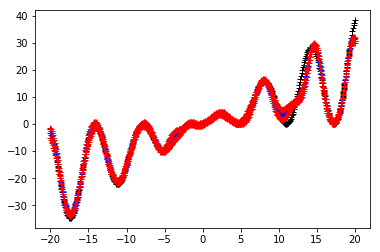

In [103]:
pred_mean, pred_covar = myGP.posterior_predictive(Xn)
plot_GP(pred_mean,pred_covar,Xn,Yn,Xn)

### During and after:

In [104]:
myGP.optimize_parameters(500,'Adam')

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


0 tensor([[nan]], grad_fn=<AddBackward0>)
50 tensor([[nan]], grad_fn=<AddBackward0>)


KeyboardInterrupt: 

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


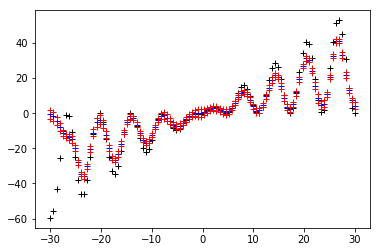

In [89]:
pred_mean, pred_covar = myGP.posterior_predictive(Xn)
plot_GP(pred_mean,pred_covar,Xn,Yn,Xn)

In [3]:
class variational_GP(nn.Module):
    
    def __init__(self, Xn, Yn):   # the GP takes the training data as arguments, in the form of numpy arrays, with the correct dimensions
        
        super().__init__()
        # initialise hyperparameters
        self.Xm = nn.Parameter(torch.Tensor(Xn[random.sample(range(Xn.shape[0]),30),:]).type(torch.FloatTensor))
        self.Xn = torch.tensor(Xn).type(torch.FloatTensor)
        self.Yn = torch.tensor(Yn).type(torch.FloatTensor)
        self.no_inputs = Xn.shape[1]
        self.logsigmaf2 = nn.Parameter(torch.Tensor([0])) # function variance
        self.logl2 = nn.Parameter(torch.zeros(self.no_inputs)) # horizontal length scales
        self.logsigman2 = nn.Parameter(torch.Tensor([0])) # noise variance
        self.jitter_factor = 1e-4
        self.log_marg = 0
        self.reg = 0
        
    def get_K(self,inputs1,inputs2):
        
        inputs1_col = torch.unsqueeze(inputs1.transpose(0,1), 2)
        inputs2_row = torch.unsqueeze(inputs2.transpose(0,1), 1)
        squared_distances = (inputs1_col - inputs2_row)**2        
        length_factors = (1/(2*torch.exp(self.logl2))).reshape(self.no_inputs,1,1)
        K = torch.exp(self.logsigmaf2) * torch.exp(-torch.sum(length_factors * squared_distances, 0))
        return(K)
    
    def Fv(self): # All the necessary arguments are instance variables, so no need to pass them

        # Compute first term (log marginal likelihood)
        
        M = self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2) * torch.mm(self.get_K(self.Xm,self.Xn),self.get_K(self.Xn,self.Xm))
        M = M + torch.eye(M.shape[0])*self.jitter_factor
        L = torch.potrf(M,upper=False)
        LslashKmnYn, _ = torch.trtrs(torch.mm(self.get_K(self.Xm,self.Xn),self.Yn),L,upper=False)
        
        import pdb; pdb.set_trace()
        
        term_pi = - self.Xn.shape[1] / 2 * torch.log(torch.Tensor([2*np.pi]))
        term_det = - 1 / 2 * (torch.logdet(self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2)*torch.mm(self.get_K(self.Xm,self.Xn),self.get_K(self.Xn,self.Xm)))
                                                  - torch.log(torch.det(self.get_K(self.Xm,self.Xm))) + self.Xn.shape[0]*self.logsigman2)
        term_quadratics =  - 1/2*(1/torch.exp(self.logsigman2)*torch.mm(self.Yn.transpose(0,1),self.Yn) 
                                   - 1/torch.exp(self.logsigman2)**2 * torch.mm(LslashKmnYn.transpose(0,1),LslashKmnYn))
        log_marg = term_pi + term_det + term_quadratics
                     
        
        
        # Compute second term (trace, regularizer)
        TrKnn = 0
        for elem in self.Xn:
            TrKnn += self.get_K(elem.unsqueeze(0),elem.unsqueeze(0))
        
        Kmm = self.get_K(self.Xm,self.Xm)
        Kmm = Kmm + torch.eye(Kmm.shape[0])*self.jitter_factor
        L = torch.potrf(Kmm,upper=False)
        LslashKmn, _ = torch.trtrs(self.get_K(self.Xm,self.Xn),L,upper=False)
        TrKKK = torch.sum(LslashKmn * LslashKmn)       
        reg = - 1/torch.exp(self.logsigman2) * TrKnn - TrKKK
        
        self.log_marg = log_marg
        self.reg = reg
        return(log_marg + reg)
    
    def posterior_predictive(self,test_inputs):
        
        test_inputs = torch.Tensor(test_inputs)
        Sigma = self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2) * torch.mm(self.get_K(self.Xn,self.Xm).transpose(0,1),
                                                              self.get_K(self.Xn,self.Xm))
        Sigma = Sigma+torch.eye(Sigma.shape[0])*self.jitter_factor

        #Mean
        L = torch.potrf(Sigma,upper=False)
        LslashKmnYn, _ = torch.trtrs(torch.mm(self.get_K(self.Xn,self.Xm).transpose(0,1),self.Yn),L,upper=False)
        aT, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmLslash = aT.transpose(0,1)
        myq = 1/torch.exp(self.logsigman2) * torch.mm(KxmLslash,LslashKmnYn)

        #Second term of the covariance

        Kmm = self.get_K(self.Xm,self.Xm)
        Kmm = Kmm + torch.eye(Kmm.shape[0])*self.jitter_factor
        L = torch.potrf(Kmm,upper=False)
        aT, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmLTslash = aT.transpose(0,1)
        LslashKmx, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmKmminvKmx = torch.mm(KxmLTslash,LslashKmx)

        #Third term of the variance

        L = torch.potrf(Sigma,upper=False)
        aT, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmLTslash = aT.transpose(0,1)
        LslashKmx, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmSigmainvKmx = torch.mm(KxmLTslash,LslashKmx)

        #Whole covariance
        kyq = self.get_K(test_inputs,test_inputs) - KxmKmminvKmx + KxmSigmainvKmx
        
        return(myq,kyq)
        
    
    def optimize_parameters(self,no_iters,method):
        
        # Set criterion and optimizer FOR NOW I'M GONNA USE ADAM ONLY
        '''if method == 'BFGS':
            optimizer = optim.LBFGS(self.parameters(), lr=1)  
        elif method == 'Adam':
            optimizer = optim.Adam(self.parameters(), lr=0.001)
        else: 
            sys.exit('method must be either \'BFGS\' or \'Adam\'') # An exception would be better
        
        for iteration in range(no_iters):
            optimizer.zero_grad()
            loss = self.Fv() # Forward
            loss.backward() # Backward
            optimizer.step() # Optimize'''
            
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for iteration in range(no_iters):
            print(iteration)
            optimizer.zero_grad()
            loss = - self.Fv() # Forward. WHY DON'T I HAVE TO NEGATE THIS?
            loss.backward() # Backward
            optimizer.step() # Optimize
            
            if iteration%50 == 0:
                print(iteration,self.Fv())

# Dataset in Titsias paper

In [4]:
    # load the 1D dataset
    with open('./data/1D/1D_200.pkl', 'rb') as f:
        train_inputs, train_outputs, test_inputs = pickle.load(f)
    no_train = train_outputs.size
    no_test = test_inputs.shape[0]

    # convert to torch tensors
    train_inputs = torch.Tensor(train_inputs)
    train_inputs = torch.unsqueeze(train_inputs, 1) # 1 dimensional data 
    train_outputs = torch.Tensor(train_outputs)
    test_inputs = torch.Tensor(test_inputs)
    test_inputs = torch.unsqueeze(test_inputs, 1) # 1 dimensional data

In [5]:
random.seed(101)
myGP = variational_GP(train_inputs.data.numpy(), np.expand_dims(train_outputs.data.numpy(),1))

In [ ]:
myGP.Fv()

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


> <ipython-input-3-cc1130245265>(38)Fv()
-> term_pi = - self.Xn.shape[1] / 2 * torch.log(torch.Tensor([2*np.pi]))
(Pdb) n
> <ipython-input-3-cc1130245265>(39)Fv()
-> term_det = - 1 / 2 * (torch.logdet(self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2)*torch.mm(self.get_K(self.Xm,self.Xn),self.get_K(self.Xn,self.Xm)))
(Pdb) term_pi
tensor([-0.9189])
(Pdb) n
> <ipython-input-3-cc1130245265>(40)Fv()
-> - torch.log(torch.det(self.get_K(self.Xm,self.Xm))) + Xn.shape[0]*self.logsigman2)
(Pdb) term_det
*** NameError: name 'term_det' is not defined
(Pdb) n
NameError: name 'Xn' is not defined
> <ipython-input-3-cc1130245265>(40)Fv()
-> - torch.log(torch.det(self.get_K(self.Xm,self.Xm))) + Xn.shape[0]*self.logsigman2)


In [131]:
myGP.log_marg

tensor([[nan]], grad_fn=<SubBackward0>)

In [132]:
myGP.reg

tensor([[-399.9574]], grad_fn=<SubBackward0>)

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


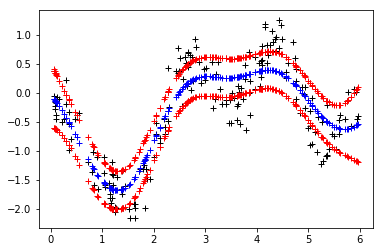

In [124]:
pred_mean, pred_covar = myGP.posterior_predictive(train_inputs.data.numpy())
plot_GP(pred_mean,pred_covar,train_inputs.data.numpy(),np.expand_dims(train_outputs.data.numpy(),1),train_inputs.data.numpy())

In [117]:
myGP.optimize_parameters(500,'Adam')

0


/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


RuntimeError: Lapack Error in potrf : the leading minor of order 1 is not positive definite at /opt/conda/conda-bld/pytorch_1549277628941/work/aten/src/TH/generic/THTensorLapack.cpp:658

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


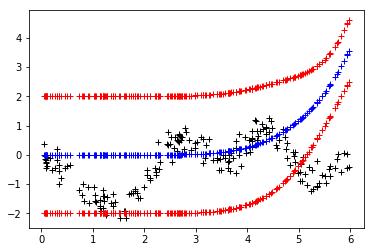

In [72]:
pred_mean, pred_covar = myGP.posterior_predictive(train_inputs.data.numpy())
plot_GP(pred_mean,pred_covar,train_inputs.data.numpy(),np.expand_dims(train_outputs.data.numpy(),1),train_inputs.data.numpy())